<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#План-проекта" data-toc-modified-id="План-проекта-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>План проекта</a></span></li><li><span><a href="#Загрузка-библиотек" data-toc-modified-id="Загрузка-библиотек-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Загрузка библиотек</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Загрузка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных-из-файла" data-toc-modified-id="Загрузка-данных-из-файла-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Загрузка данных из файла</a></span></li><li><span><a href="#Ресемплирование-данных" data-toc-modified-id="Ресемплирование-данных-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Ресемплирование данных</a></span></li></ul></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Анализ данных</a></span></li></ul></div>

# Временные ряды. Проект

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Данные лежат в файле `datasets/taxi.csv`
Количество заказов находится в столбце `num_orders` (от англ. number of orders, «число заказов»).

## План проекта

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Загрузка библиотек

In [1]:
# обновляю библиотеку

!pip install --upgrade scikit-learn -q

In [3]:
# устанавливаю библиотеку

!pip install xgboost -q

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

## Загрузка данных

### Загрузка данных из файла

Сначала просто прочтем данные:
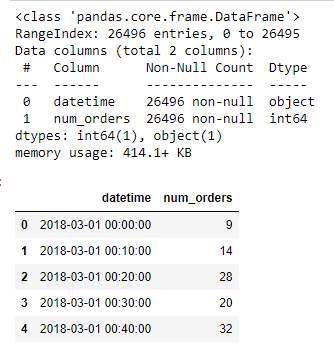

Теперь сразу при загрузке обработаем колонку с датой, превратив ее в индексы.

In [6]:
try:
    data = pd.read_csv('C:\\Users\\ElenaB\\Projects\\pj_16\\taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

data.info()    
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
# проверим наши данные на хронологию

data.sort_index(inplace=True)
print(data.index.is_monotonic)

True


Данные отсортированы корректно. Исходя из первых пяти строк, сейчас данные зафиксированы для каждых 10 минут.

### Ресемплирование данных

Необходимо произвести ресемплирование данных к 1 часу.

Поскольку данные снимались каждые десять минут, можно предположить, что это количество новых, необработанных заказов такси. Поэтому после ресемплирования данные будем суммировать.

In [11]:
data = data.resample('1H').sum() 
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Наши данные теперь обработаны за период с 0 часов 1 марта 2018 года по 23 часа ровно 31 августа 2018 года.

Построим общий график данных.

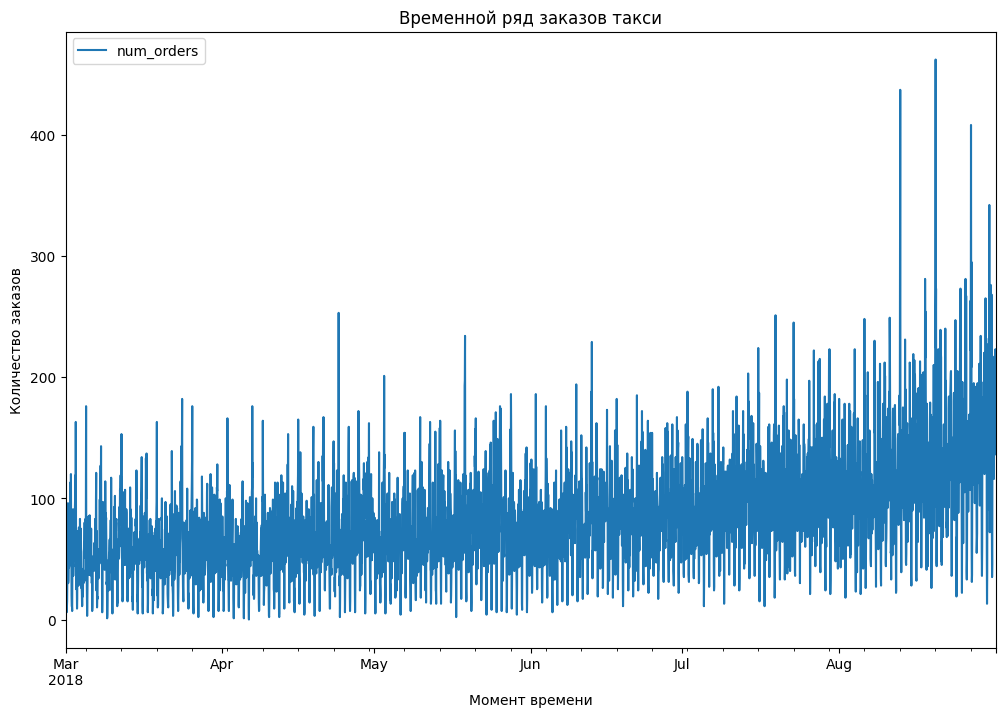

In [12]:
plt.rcParams['figure.figsize'] = [12, 8]
data.plot()
plt.title('Временной ряд заказов такси')
plt.xlabel('Момент времени')
plt.ylabel('Количество заказов')
plt.show()

## Анализ данных